<a href="https://colab.research.google.com/github/alex-smith-uwec/CS-420/blob/main/KnowledgeGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import pandas as pd
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt


pd.set_option('display.max_colwidth', 600)
%matplotlib inline

In [ ]:
from google.colab import data_table

In [ ]:
data_table.enable_dataframe_formatter()

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/NLP/Witt/df_Tractus.csv', index_col=False)

In [ ]:
sentences=df.Sentence.tolist()
numbers=df.Number.tolist()

In [ ]:
df

In [ ]:
sentences=[sen.lower() for sen in sentences]

# Following this https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook



In [ ]:
doc = nlp(sentences[0])

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
world ... nsubj
is ... ROOT
everything ... attr
that ... nsubj
is ... relcl
the ... det
case ... attr
. ... punct


In [ ]:
sentences[0]

'the world is everything that is the case.'

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
print(get_entities(sentences[12]))
print(sentences[12])

['words', 'alone  proposition']
the thing is independent, in so far as it can occur in all possible circumstances, but this form of independence is a form of connexion with the atomic fact, a form of dependence. (it is impossible for words to occur in two different ways, alone and in the proposition.)


In [ ]:
entity_pairs = []

for sen in sentences:
  entity_pairs.append(get_entities(sen))

In [ ]:
entity_pairs[10:20]

[['atomic  possibility', 'already  thing'],
 ['subsequently  state', 'affairs'],
 ['words', 'alone  proposition'],
 ['then  i', 'atomic  facts'],
 ['i', 'external'],
 ['objects', ''],
 ['atomic  i', 'empty  space'],
 ['infinite  point', 'space'],
 ['objects', 'affairs'],
 ['possibility', 'atomic  object']]

In [ ]:
sentences[17]

'a spatial object must lie in infinite space. (a point in space is an argument place.)'

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object
  matcher = Matcher(nlp.vocab)

  #define the pattern
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

  matcher.add("matching_1",[pattern])

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

In [ ]:
get_relation(sentences[210])

'shows'

In [ ]:
relations = [get_relation(sen) for sen in sentences]

In [ ]:
pd.Series(relations).value_counts()[:50]

is                121
are                32
be                 15
is clear           10
say                 9
has                 7
shows               6
says                6
represents          5
know                5
express             4
mean                4
understand          4
determines          4
expressed           3
contains            3
expresses           3
corresponds to      3
presents            3
given               3
characterize        3
depends             3
expressed by        3
speak               3
consists of         3
said                2
give                2
written in          2
follows from        2
}                   2
provides            2
asserts             2
answer              2
introduce           2
is possible         2
proves              2
f                   2
means               2
stand to            2
be capable          2
tr                  2
bring               2
becomes clear       2
be true             2
believe             2
compare   

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
source[0:10]

['that',
 'world',
 'these',
 'also  that',
 'facts',
 'world',
 'everything',
 'fact',
 'atomic  fact',
 'it']

In [ ]:
target[0:10]

['',
 'things',
 'facts',
 'facts',
 'logical  space',
 'facts',
 '',
 'atomic  facts',
 'objects',
 'atomic  fact']

In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

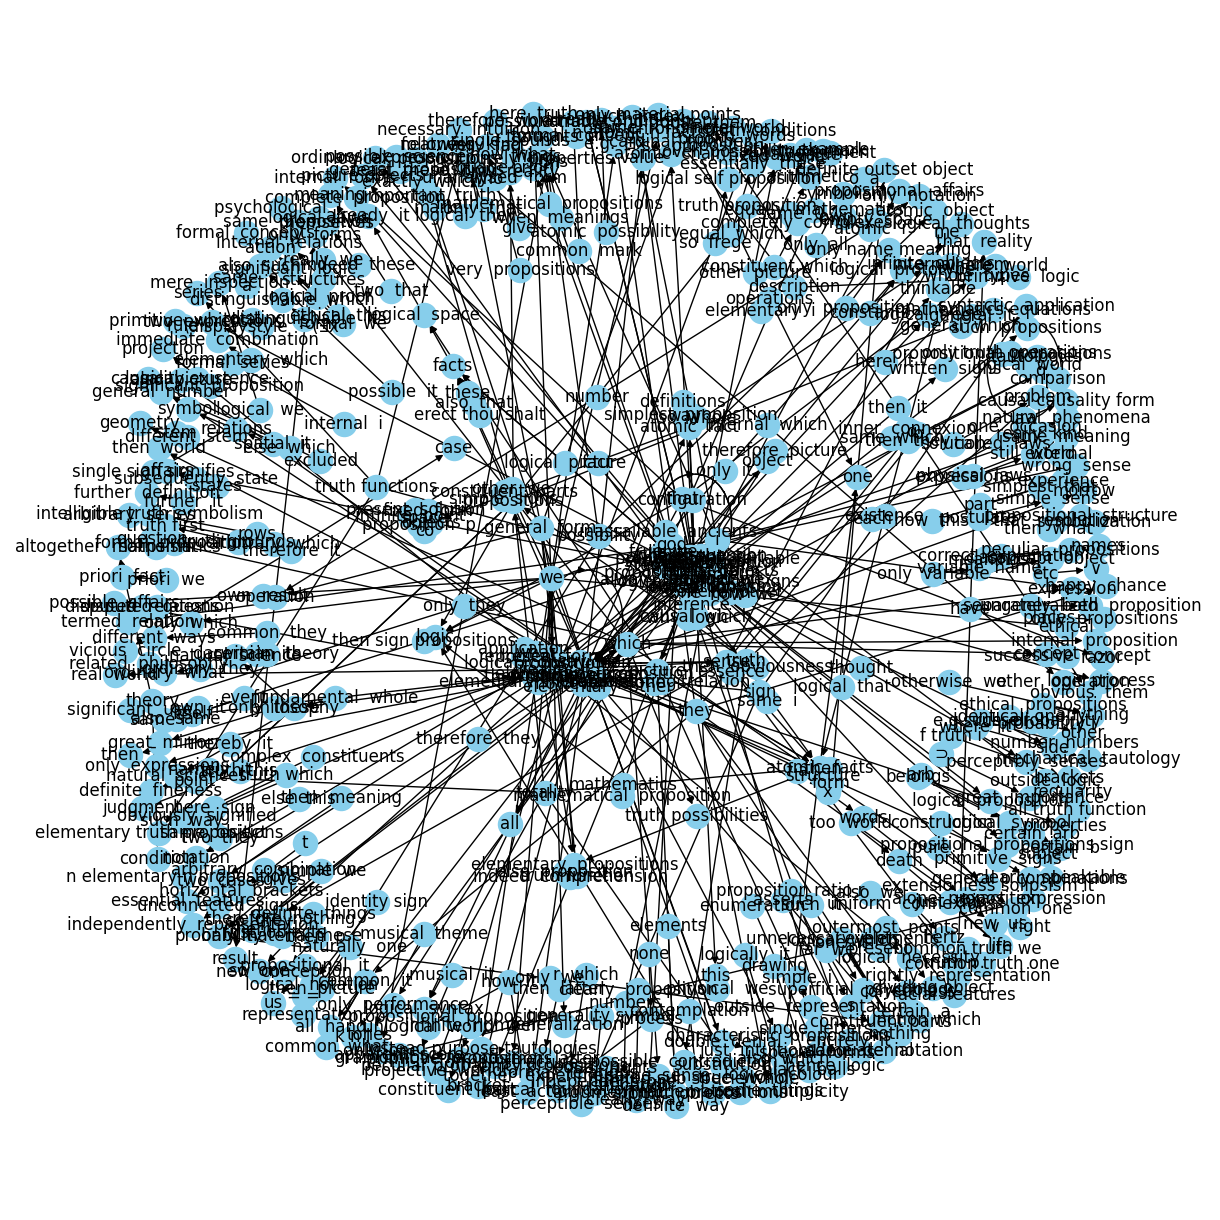

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

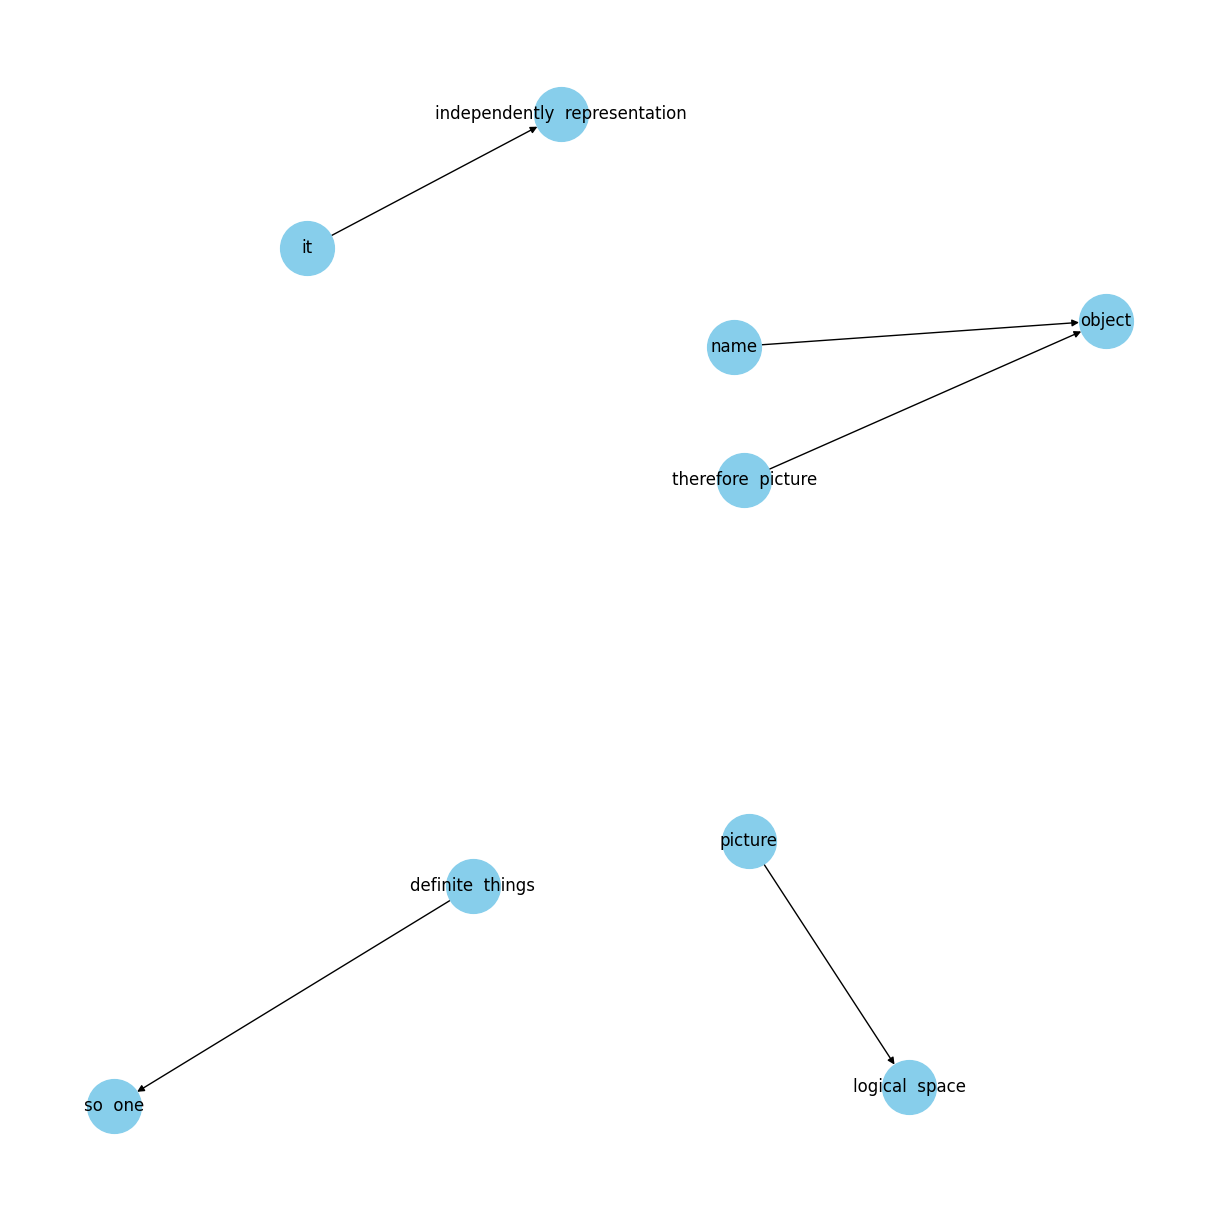

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="represents"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
len(numbers)

526

# Now switching to these ideas https://arxiv.org/pdf/1703.04336.pdf especially the concept network in 3.2

In [ ]:
doc=nlp(sentences[0])
print("Nouns:", [token.lemma_ for token in doc if token.pos_ == "NOUN"])

Nouns: ['world', 'case']


In [ ]:
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])

Noun phrases: ['the world', 'everything', 'that', 'the case']


In [ ]:
sentences[525]

'whereof one cannot speak, thereof one must be silent.'

In [ ]:
group1=sentences[0:6]
group2=sentences[7:86]
group3=sentences[87:160]
group4=sentences[161:269]
group5=sentences[270:420]
group6=sentences[421:524]
group7=sentences[-1]

In [ ]:
# sentences[525]
group7

'whereof one cannot speak, thereof one must be silent.'

In [ ]:
nouns1 = []
for sentence in group1:
    doc = nlp(sentence)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    nouns1.append(nouns)


nouns2 = []
for sentence in group2:
    doc = nlp(sentence)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    nouns2.append(nouns)

nouns3 = []
for sentence in group3:
    doc = nlp(sentence)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    nouns3.append(nouns)

nouns4 = []
for sentence in group4:
    doc = nlp(sentence)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    nouns4.append(nouns)

nouns5 = []
for sentence in group5:
    doc = nlp(sentence)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    nouns5.append(nouns)

nouns6 = []
for sentence in group6:
    doc = nlp(sentence)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    nouns6.append(nouns)

nouns7 = []
for sentence in group7:
    doc = nlp(sentence)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    nouns7.append(nouns)


In [ ]:
sentences[-3]

'the right method of philosophy would be this. to say nothing except what can be said, i.e. the propositions of natural science, i.e. something that has nothing to do with philosophy: and then always, when someone else wished to say something metaphysical, to demonstrate to him that he had given no meaning to certain signs in his propositions. this method would be unsatisfying to the other—he would not have the feeling that we were teaching him philosophy—but it would be the only strictly correct method.'

In [ ]:
nouns1

[['world', 'case'],
 ['world', 'totality', 'fact', 'thing'],
 ['world', 'fact', 'fact'],
 ['totality', 'fact', 'case', 'case'],
 ['fact', 'space', 'world'],
 ['world', 'fact']]

In [ ]:
nlp(sentences[0])


the world is everything that is the case.

In [ ]:
print(nouns6)

[['proposition', 'result', 'application', 'operation', '¯', 'proposition'], ['form', 'way', 'proposition', 'form', 'way', 'operation', 'proposition'], ['form', 'operation', '′', '¯', '¯', '¯', '′', '¯', '¯', '¯', '¯', 'n({\\bar', 'n({\\bar'], ['number'], ['number', 'exponent', 'operation'], ['concept', 'number', 'number', 'form', 'number'], ['form', 'number'], ['theory', 'class', 'mathematic'], ['proposition', 'logic', 'tautology'], ['proposition', 'logic', 'proposition'], ['theory', 'proposition', 'logic', 'word', 'property', 'property', 'fact', 'proposition', 'property', 'mean', 'self', 'proposition', 'rose', 'proposition', 'character', 'proposition', 'science', 'symptom'], ['explanation', 'proposition', 'position', 'proposition'], ['mark', 'proposition', 'symbol', 'fact', 'philosophy', 'logic', 'fact', 'truth', 'falsehood', 'proposition', 'proposition'], ['fact', 'proposition', 'logic', 'tautology', 'property', 'language', 'world'], ['proposition', 'p', 'connexion', 'tautology', 'pr

In [ ]:
from collections import Counter

In [ ]:
list_of_lists = nouns1

# Flatten the list of lists into a single list
flat_list = [item for sublist in list_of_lists for item in sublist]

# Use Counter to count the frequencies of each item in the list
freq_dict1 = dict(Counter(flat_list))

print(freq_dict1)



list_of_lists = nouns2

# Flatten the list of lists into a single list
flat_list = [item for sublist in list_of_lists for item in sublist]

# Use Counter to count the frequencies of each item in the list
freq_dict2 = dict(Counter(flat_list))

print(freq_dict2)

list_of_lists = nouns3

# Flatten the list of lists into a single list
flat_list = [item for sublist in list_of_lists for item in sublist]

# Use Counter to count the frequencies of each item in the list
freq_dict3 = dict(Counter(flat_list))

print(freq_dict3)

list_of_lists = nouns4

# Flatten the list of lists into a single list
flat_list = [item for sublist in list_of_lists for item in sublist]

# Use Counter to count the frequencies of each item in the list
freq_dict4 = dict(Counter(flat_list))
print(freq_dict4)

list_of_lists = nouns5

# Flatten the list of lists into a single list
flat_list = [item for sublist in list_of_lists for item in sublist]

# Use Counter to count the frequencies of each item in the list
freq_dict5 = dict(Counter(flat_list))
print(freq_dict5)

list_of_lists = nouns6

# Flatten the list of lists into a single list
flat_list = [item for sublist in list_of_lists for item in sublist]

# Use Counter to count the frequencies of each item in the list
freq_dict6 = dict(Counter(flat_list))
print(freq_dict6)

list_of_lists = nouns7

# Flatten the list of lists into a single list
flat_list = [item for sublist in list_of_lists for item in sublist]

# Use Counter to count the frequencies of each item in the list
freq_dict7 = dict(Counter(flat_list))
print(freq_dict7)


{'world': 5, 'case': 3, 'totality': 2, 'fact': 6, 'thing': 1, 'space': 1}
{'case': 2, 'fact': 31, 'existence': 11, 'combination': 1, 'object': 24, 'entity': 1, 'thing': 13, 'part': 2, 'logic': 1, 'possibility': 8, 'accident': 1, 'account': 1, 'state': 4, 'affair': 4, 'circumstance': 1, 'form': 25, 'independence': 1, 'connexion': 1, 'dependence': 1, 'word': 1, 'way': 5, 'proposition': 5, 'occurrence': 2, 'order': 6, 'quality': 1, 'space': 8, 'point': 2, 'argument': 1, 'place': 1, 'statement': 2, 'complex': 2, 'constituent': 1, 'substance': 4, 'world': 10, 'sense': 3, 'picture': 43, 'one': 2, 'material': 1, 'property': 4, 'configuration': 3, 'other': 1, 'description': 1, 'hand': 2, 'totality': 3, 'content': 1, 'time': 1, 'colour': 1, 'colouredness': 1, 'existent': 2, 'variable': 1, 'link': 1, 'chain': 1, 'structure': 4, 'reality': 14, 'model': 1, 'element': 7, 'stand': 1, 'representation': 8, 'scale': 1, 'dividing': 1, 'line': 1, 'view': 1, 'relation': 2, 'co': 2, '-': 2, 'ordination': 2

In [ ]:
nouns_all = []
for sentence in sentences:
    doc = nlp(sentence)
    window = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    nouns_all.append(window)

In [ ]:
nouns_all[1]

['world', 'totality', 'fact', 'thing']

In [ ]:
noun_list = []

for inner_list in nouns_all:
    for item in inner_list:
        noun_list.append(item)

In [ ]:
noun_count=Counter(noun_list)
sorted_noun_count = noun_count.most_common()


In [ ]:
sorted_noun_count[0:20]

[('proposition', 322),
 ('fact', 96),
 ('sign', 92),
 ('form', 88),
 ('truth', 68),
 ('world', 67),
 ('object', 63),
 ('picture', 62),
 ('logic', 54),
 ('sense', 50),
 ('p', 50),
 ('thing', 42),
 ('relation', 36),
 ('operation', 32),
 ('possibility', 31),
 ('law', 30),
 ('number', 30),
 ('existence', 29),
 ('way', 29),
 ('reality', 29)]

In [ ]:
def first_appearance(word):
  dicts=[freq_dict1,freq_dict2,freq_dict3,freq_dict4,freq_dict5,freq_dict6,freq_dict7]
  for i, d in enumerate(dicts, start=1):
        if word in d:
            return i
  return "None"  # If the word is not found in any dictionary, return None




In [ ]:
first_appearance('totality')

1

In [ ]:
list_of_lists = nouns_all

# Flatten the list of lists into a single list...this is probably the same as noun_list defined above
flat_list = [item for sublist in list_of_lists for item in sublist]

# Use Counter to count the frequencies of each item in the list
freq_dict_all = dict(Counter(flat_list))

In [ ]:
print(freq_dict_all)

{'world': 67, 'case': 22, 'totality': 14, 'fact': 96, 'thing': 42, 'space': 17, 'one': 10, 'existence': 29, 'combination': 11, 'object': 63, 'entity': 1, 'part': 13, 'logic': 54, 'possibility': 31, 'accident': 2, 'account': 1, 'state': 18, 'affair': 18, 'circumstance': 2, 'form': 88, 'independence': 1, 'connexion': 10, 'dependence': 1, 'word': 13, 'way': 29, 'proposition': 322, 'occurrence': 4, 'order': 16, 'quality': 1, 'point': 11, 'argument': 10, 'place': 12, 'statement': 2, 'complex': 5, 'constituent': 4, 'substance': 4, 'sense': 50, 'picture': 62, 'material': 3, 'property': 24, 'configuration': 5, 'other': 7, 'description': 18, 'hand': 5, 'content': 1, 'time': 5, 'colour': 3, 'colouredness': 1, 'existent': 2, 'variable': 18, 'link': 1, 'chain': 1, 'structure': 13, 'reality': 29, 'model': 2, 'element': 11, 'stand': 2, 'representation': 11, 'scale': 1, 'dividing': 1, 'line': 4, 'view': 3, 'relation': 36, 'co': 12, '-': 12, 'ordination': 6, 'feeler': 1, 'manner': 3, 'standpoint': 3, 

In [ ]:
# data = [['world', 'case'], ['world','case'],['world', 'totality', 'fact', 'thing'], ['world', 'fact', 'fact'],
#         ['totality', 'fact', 'case', 'case'], ['fact', 'space', 'world'], ['world', 'fact']]

data=nouns_all
pair_count = {}

for sublist in data:
  for i in range(len(sublist)):
        for j in range(len(sublist)):
            pair = tuple(sorted((sublist[i], sublist[j])))
            if len(set(pair))==2 and  pair not in pair_count:
              pair_count[pair] = 1
            else:
              if len(set(pair))==2 and pair in pair_count:
                    pair_count[pair] += 1


pair_count = {k: int(v/2) for k, v in pair_count.items()}


print(pair_count)

{('case', 'world'): 3, ('totality', 'world'): 4, ('fact', 'world'): 14, ('thing', 'world'): 5, ('fact', 'totality'): 7, ('thing', 'totality'): 3, ('fact', 'thing'): 16, ('case', 'totality'): 2, ('case', 'fact'): 5, ('fact', 'space'): 12, ('space', 'world'): 1, ('case', 'one'): 5, ('case', 'existence'): 1, ('existence', 'fact'): 22, ('combination', 'fact'): 1, ('fact', 'object'): 20, ('entity', 'fact'): 1, ('combination', 'object'): 1, ('combination', 'entity'): 1, ('combination', 'thing'): 1, ('entity', 'object'): 1, ('object', 'thing'): 4, ('entity', 'thing'): 1, ('part', 'thing'): 1, ('fact', 'part'): 2, ('logic', 'thing'): 3, ('fact', 'logic'): 11, ('logic', 'possibility'): 2, ('possibility', 'thing'): 5, ('fact', 'possibility'): 9, ('accident', 'thing'): 1, ('accident', 'account'): 1, ('accident', 'state'): 1, ('accident', 'affair'): 1, ('account', 'thing'): 1, ('state', 'thing'): 2, ('affair', 'thing'): 2, ('account', 'state'): 1, ('account', 'affair'): 1, ('affair', 'state'): 22,

In [ ]:
df = pd.DataFrame.from_dict(pair_count, orient='index', columns=['count'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['word1', 'word2'])
# df_sorted = df.sort_index(level='word1')

In [ ]:
# create the DataFrame
df = pd.DataFrame(list(pair_count.items()), columns=['words', 'count'])

# split the words tuple into separate columns
df[['word1', 'word2']] = pd.DataFrame(df['words'].tolist(), index=df.index)

# drop the 'words' column
df = df.drop(columns=['words'])

# sort the DataFrame based on count in descending order
df = df.sort_values(by='count', ascending=False)

# display the DataFrame
df_tops = df.head(20)
df_tops

count        word1        word2
1593    102  proposition        truth
62       62         form  proposition
1273     58            p  proposition
840      56        logic  proposition
126      47  proposition        sense
782      45            p            q
77       43         fact  proposition
391      41  proposition         sign
122      41  proposition        world
1591     35       number  proposition
507      32  proposition       symbol
408      31  proposition     relation
1751     30  description         form
145      30     property  proposition
2017     29    operation  proposition
1507     28       series         term
1915     28  proposition            r
506      27   expression  proposition
324      27        logic        world
1795     26       ground  proposition

In [ ]:
df.to_csv('/content/drive/MyDrive/NLP/Scratch/pair_count.csv')

In [ ]:
df

count        word1        word2
1593    102  proposition        truth
62       62         form  proposition
1273     58            p  proposition
840      56        logic  proposition
126      47  proposition        sense
...     ...          ...          ...
2049      1            p           p.
2052      1   difference    operation
2056      1    operation            q
2057      1         fact    operation
4311      1       ladder    senseless

[4312 rows x 3 columns]

In [ ]:
GraphData = pd.read_csv ('/content/drive/MyDrive/NLP/Scratch/ConceptGraphEdges.csv')
df_top=GraphData.head(150)

In [ ]:
G=nx.from_pandas_edgelist(df_top,'word1', 'word2')#


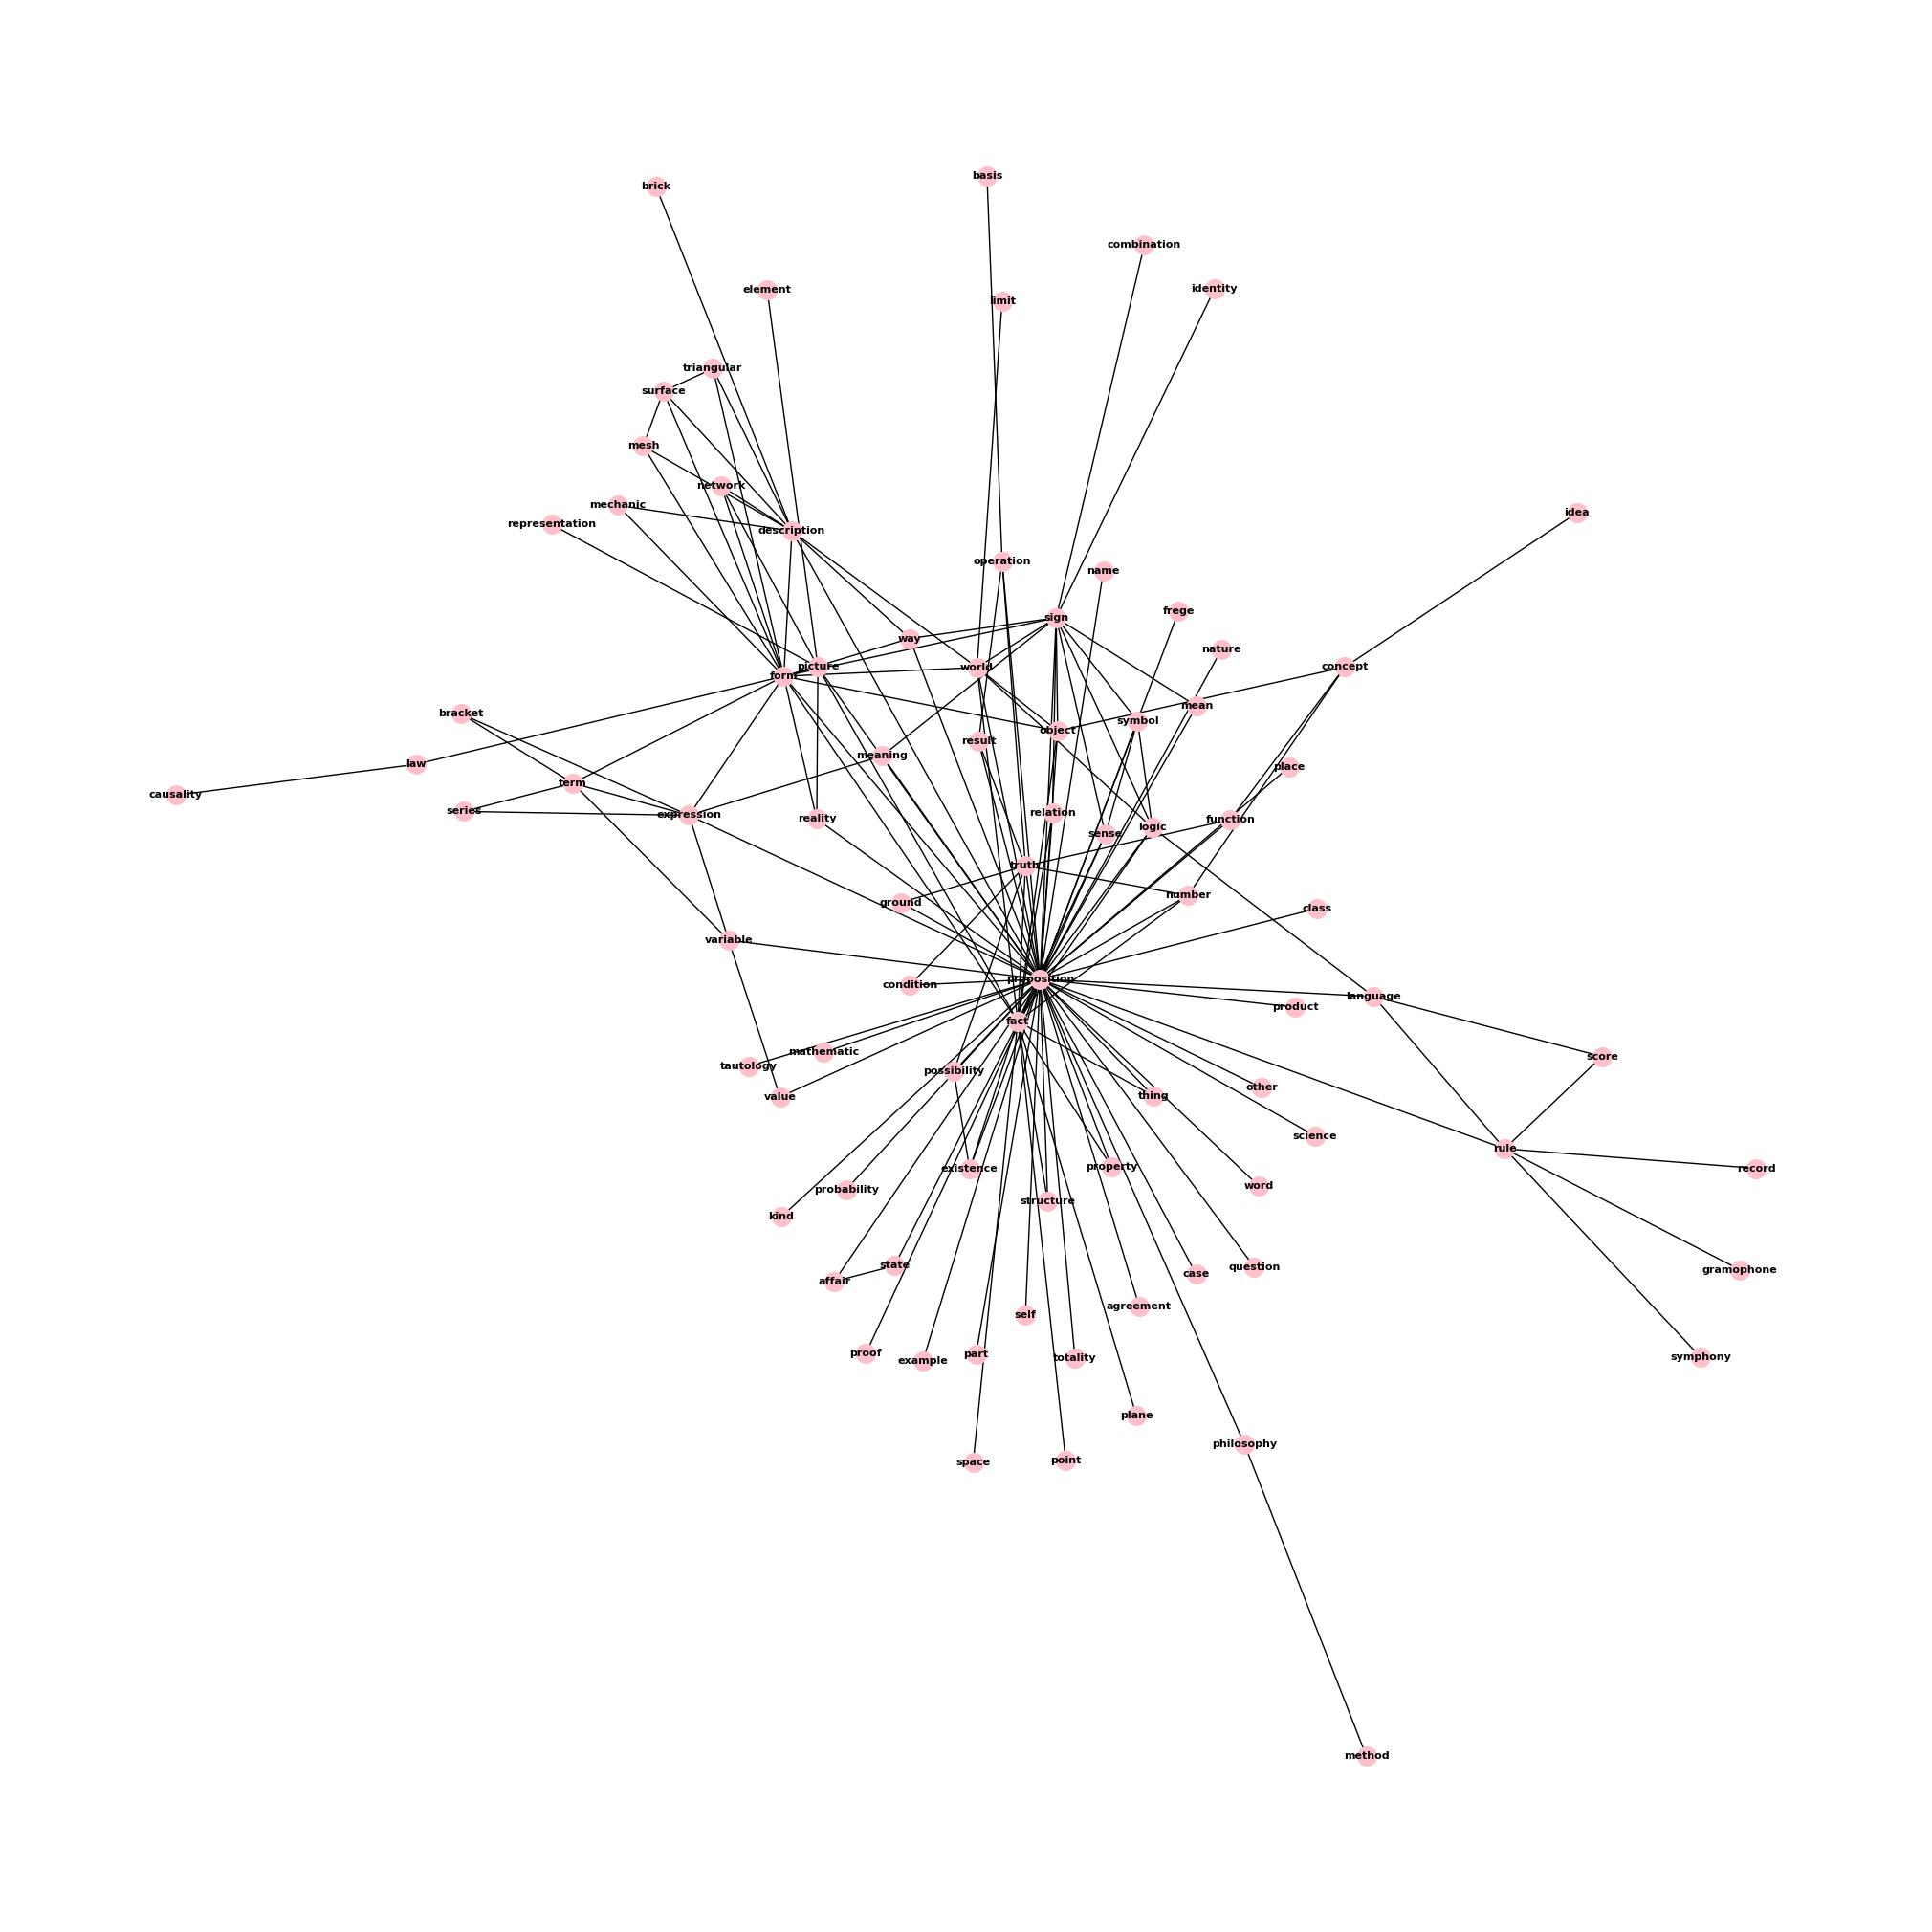

In [ ]:
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G)
#layout options here https://networkx.org/documentation/stable/reference/drawing.html
nx.draw(G, with_labels=True, node_color='pink',font_size=8,font_weight='bold', node_size=200,edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
G.nodes()

NodeView(('proposition', 'truth', 'form', 'logic', 'sense', 'fact', 'sign', 'world', 'number', 'symbol', 'relation', 'description', 'property', 'operation', 'series', 'term', 'expression', 'picture', 'ground', 'meaning', 'surface', 'existence', 'object', 'affair', 'state', 'tautology', 'way', 'part', 'function', 'agreement', 'mean', 'variable', 'name', 'class', 'thing', 'mesh', 'possibility', 'reality', 'triangular', 'frege', 'language', 'case', 'rule', 'point', 'combination', 'bracket', 'totality', 'mathematic', 'result', 'score', 'symphony', 'causality', 'law', 'mechanic', 'self', 'word', 'concept', 'science', 'brick', 'network', 'nature', 'place', 'other', 'probability', 'proof', 'space', 'method', 'philosophy', 'condition', 'example', 'question', 'idea', 'plane', 'kind', 'product', 'representation', 'gramophone', 'record', 'identity', 'structure', 'value', 'limit', 'basis', 'element'))

In [ ]:
first_appearance('proposition')

2

In [ ]:
!apt install libgraphviz-dev --quiet
!pip install pygraphviz --quiet
import pygraphviz as pgv

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 13 not upgraded.
Need to get 2,148 kB of archives.
After this operation, 7,427 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-common all 2.24.32-4ubuntu4 [126 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-0 amd64 2.24.32-4ubuntu4 [1,791 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libgail18 amd64 2.24.32-4ubuntu4 [14.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/main amd64 libgail-common amd64 2.24.32-4ubuntu4 [116 kB]

In [ ]:
from IPython.display import Image

In [ ]:
# G.edges()

In [ ]:
A=nx.nx_agraph.to_agraph(G)

In [ ]:
print(A.get_node('proposition').attr)

In [ ]:
for node in A.nodes():
    # if '.' in node:
    #     leading_digit = node.split('.')[0]
    leading_digit = str(first_appearance(node))
    if leading_digit == '1':
        A.get_node(node).attr['fillcolor'] = 'coral'
    elif leading_digit == '2':
        A.get_node(node).attr['fillcolor'] = 'green'
    elif leading_digit == '3':
        A.get_node(node).attr['fillcolor'] = 'aqua'
    elif leading_digit == '4':
        A.get_node(node).attr['fillcolor'] = 'yellow'
    elif leading_digit == '5':
        A.get_node(node).attr['fillcolor'] = 'bisque1'
    elif leading_digit == '6':
        A.get_node(node).attr['fillcolor'] = 'cyan'
    elif leading_digit == '7':
        A.get_node(node).attr['fillcolor'] = 'red'

# draw the graph
A.node_attr['style']='filled'
A.draw('graph.png', prog='dot')#also fdp, sfdp, neato, dot,circo, osage etc

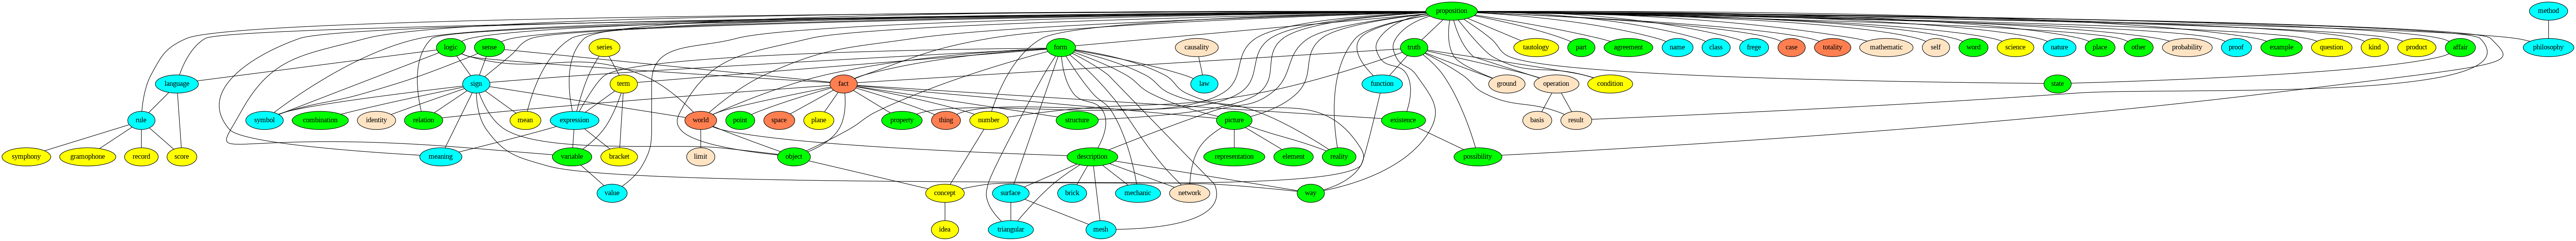

In [ ]:
Image('graph.png')

In [ ]:
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.2 MB/s eta 0:00:00


In [ ]:
G.nodes

NodeView(('proposition', 'truth', 'form', 'logic', 'sense', 'fact', 'sign', 'world', 'number', 'symbol', 'relation', 'description', 'property', 'operation', 'series', 'term', 'expression', 'picture', 'ground', 'meaning', 'surface', 'existence', 'object', 'affair', 'state', 'tautology', 'way', 'part', 'function', 'agreement', 'mean', 'variable', 'name', 'class', 'thing', 'mesh', 'possibility', 'reality', 'triangular', 'frege', 'language', 'case', 'rule', 'point', 'combination', 'bracket', 'totality', 'mathematic', 'result', 'score', 'symphony', 'causality', 'law', 'mechanic', 'self', 'word', 'concept', 'science', 'brick', 'network', 'nature', 'place', 'other', 'probability', 'proof', 'space', 'method', 'philosophy', 'condition', 'example', 'question', 'idea', 'plane', 'kind', 'product', 'representation', 'gramophone', 'record', 'identity', 'structure', 'value', 'limit', 'basis', 'element'))

In [ ]:
from pyvis.network import Network
net = Network()
for node in G.nodes():
    net.add_node(node)
for edge in G.edges():
    net.add_edge(*edge)


In [ ]:
net.nodes

[{'color': '#97c2fc',
  'id': 'proposition',
  'label': 'proposition',
  'shape': 'dot'},
 {'color': '#97c2fc', 'id': 'truth', 'label': 'truth', 'shape': 'dot'},
 {'color': '#97c2fc', 'id': 'form', 'label': 'form', 'shape': 'dot'},
 {'color': '#97c2fc', 'id': 'logic', 'label': 'logic', 'shape': 'dot'},
 {'color': '#97c2fc', 'id': 'sense', 'label': 'sense', 'shape': 'dot'},
 {'color': '#97c2fc', 'id': 'fact', 'label': 'fact', 'shape': 'dot'},
 {'color': '#97c2fc', 'id': 'sign', 'label': 'sign', 'shape': 'dot'},
 {'color': '#97c2fc', 'id': 'world', 'label': 'world', 'shape': 'dot'},
 {'color': '#97c2fc', 'id': 'number', 'label': 'number', 'shape': 'dot'},
 {'color': '#97c2fc', 'id': 'symbol', 'label': 'symbol', 'shape': 'dot'},
 {'color': '#97c2fc', 'id': 'relation', 'label': 'relation', 'shape': 'dot'},
 {'color': '#97c2fc',
  'id': 'description',
  'label': 'description',
  'shape': 'dot'},
 {'color': '#97c2fc', 'id': 'property', 'label': 'property', 'shape': 'dot'},
 {'color': '#97c2f

In [ ]:
for node in net.nodes:
    leading_digit = str(first_appearance(node['id']))
    if leading_digit == '1':
        node['color'] = 'coral'
    elif leading_digit == '2':
        node['color'] = 'green'
    elif leading_digit == '3':
        node['color'] = 'aqua'
    elif leading_digit == '4':
        node['color'] = 'yellow'
    elif leading_digit == '5':
        node['color'] = 'bisque1'
    elif leading_digit == '6':
        node['color'] = 'cyan'
    elif leading_digit == '7':
        node['color'] = 'red'




In [ ]:
from pyvis.network import Network
from IPython.core.display import display, HTML

# create a pyvis network object
net = Network(height='800px', width='100%', notebook=True, cdn_resources='in_line')

# add nodes and edges from the networkx graph
for node in G.nodes():
    net.add_node(node)
for edge in G.edges():
    net.add_edge(*edge)

# show the network in a Jupyter notebook
net.show('ConceptGraph.html')
display(HTML('ConceptGraph.html'))


ConceptGraph.html
